# Importing

In [1]:
%matplotlib widget

In [2]:
# import libaries
import importlib
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import ticker, rcParams
import plotly.graph_objects as go
from pathlib import Path
from numpy.linalg import eigh
from math import atan2, degrees

import Erythropoiesis_sim as Esim
import consts
import disease

importlib.reload(Esim)
importlib.reload(consts)
importlib.reload(disease)

from disease import Disease  # noqa: E402


In [3]:
path = "~/Library/Mobile Documents/com~apple~CloudDocs/Herut/Python/Homeostasis_feedback_loops/"

In [4]:
# Define your desired folder
save_dir = Path(
    "/Users/herutuzan/Documents/Research/Uri Alon/Hematopoasis/Plos computional biology"
).expanduser()
save_dir.mkdir(parents=True, exist_ok=True)  # create it if it doesn’t exist

In [5]:
sd_params = {
    "gamma_c": 0.2,  # final value
    "gamma_e": 0.3,  # maximal value: 0.3
    "h_max": 0.3,  # maximal value: 0.4
    "e_max": 0.1,  # maximal value: 0.1
    "c_normalization_epo": 0.05,  # maximal value: 0.1
    "a_max": 0.1,  # maximal value: 0.1
    "d_max": 0.1,  # maximal value: 0.1
    "k_a": 0.2,  # maximal value: 0.4
    "k_d": 0.2,  # maximal value: 0.4
}

# The model

In [12]:
disease = Disease("norm")

In [13]:
model = disease.model

In [ ]:
disease.run_simulation()
results = disease.results

# Plot the results
results.plot()

In [ ]:
results.plot_all(disease.dt, disease.t_end, purturbation=disease.perturbation)

In [ ]:
# disease.load_simulation_data(path)

In [14]:
disease.simulate_population_variability(n_samples=150, sd_params=sd_params)

100%|██████████| 150/150 [01:12<00:00,  2.06it/s]


log(EPO) = -0.137 * Hb + 2.947


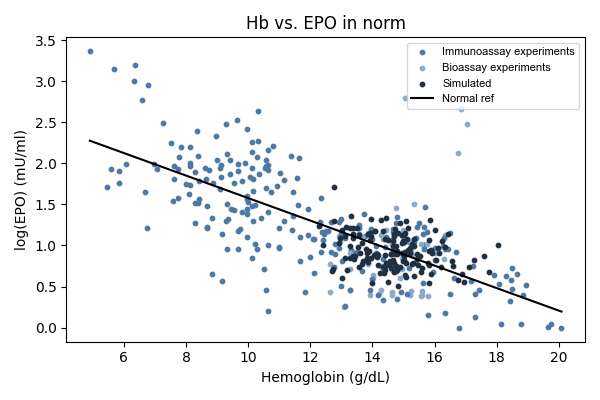

In [15]:
disease.compare_to_exp_data(save_fig=True)

In [ ]:
disease.print_stats()

In [ ]:
disease.calculate_wasserstein_distance()

In [ ]:
nullcline_plotter = disease.plot_nullclines()

In [ ]:
m, b = disease.fit_epo_curve()

In [ ]:
disease.print_exp_data()

In [ ]:
disease.save_simulation_data(path)

# Validation by different clinical scenarios 

## The relationship between hemoglobin (g/dL) and log(EPO) (mU/ml)

Normal Fit: log(EPO) = -0.15*Hb + 3.04


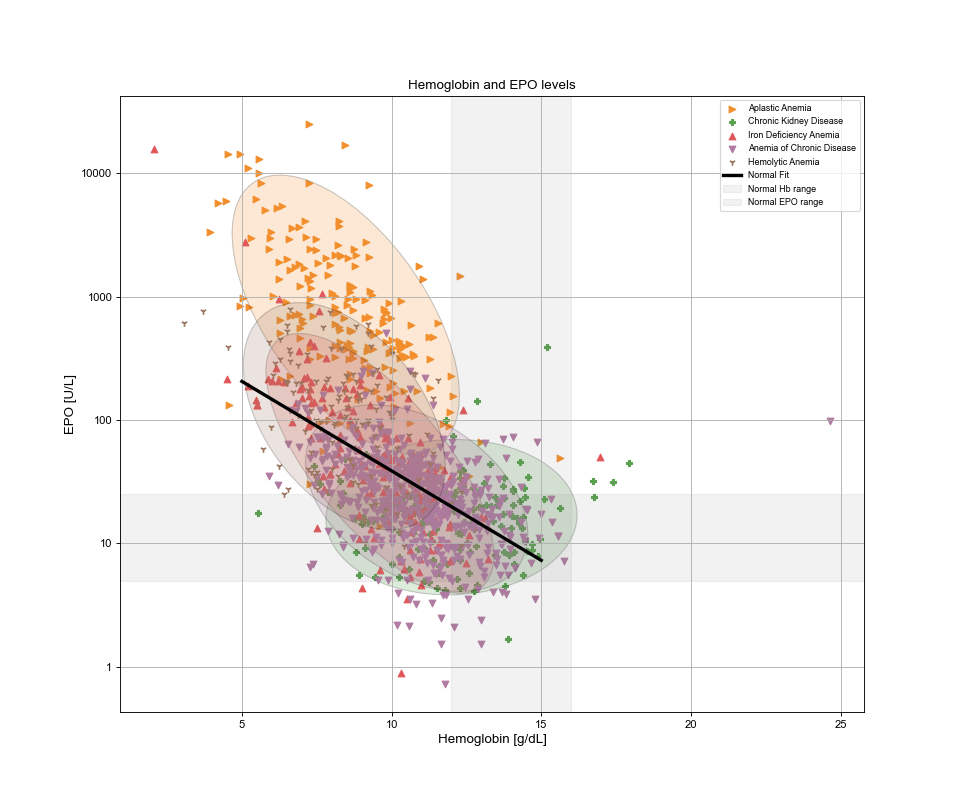

In [5]:
# --- Helper function to plot a covariance ellipse ---
def plot_cov_ellipse(
    X, ax=None, n_sigma=2.0, facecolor="none", edgecolor="black", alpha=0.8, label=None
):
    """
    Plots an n-sigma ellipse for the 2D data in X (N×2: [Hb, logEPO]).
    n_sigma=2 encloses ~95% if data are roughly Gaussian.
    """
    if ax is None:
        ax = plt.gca()
    if len(X) < 2:
        return  # Avoid errors for single data points

    mu = np.mean(X, axis=0)  # Mean [Hb, logEPO]
    cov = np.cov(X, rowvar=False)  # Covariance matrix (2×2)
    vals, vecs = np.linalg.eigh(cov)  # Eigenvalues & eigenvectors
    vals, vecs = vals[::-1], vecs[:, ::-1]  # Sort eigenvalues descending

    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))  # Rotation angle
    width, height = 2 * n_sigma * np.sqrt(vals)  # Ellipse dimensions

    ell = Ellipse(
        xy=mu,
        width=width,
        height=height,
        angle=theta,
        facecolor=facecolor,
        edgecolor=edgecolor,
        alpha=alpha,
        label=label,
    )
    ax.add_patch(ell)


# --- Define File Names ---
base_dir = Path(path + "/EPO_Hb").expanduser()
files_names = list(base_dir.glob("*.xlsx"))

plt.figure(figsize=(12, 10), dpi=80)

# Store normal data separately for global fitting
norm_Hb = []
norm_logEPO = []

# Dictionary to store grouped disease data
disease_groups = {}

for file_name in files_names:
    # Skip on file name containing the string bioassay
    if "bioassay" in file_name.name:
        continue
    data = pd.read_excel(file_name)
    Hb = data["Hb"].values
    log_EPO = data["logEPO"].values

    # Extract disease from filename - the string between / to _
    # Example: "EPO_Hb/IDA_Artunc.xlsx" -> "IDA"
    disease = file_name.stem.split("_", 1)[0]

    # Use predefined color and marker
    color = consts.disease_colors.get(disease, "black")  # Default to black if missing
    marker = consts.disease_markers.get(disease, "o")  # Default to 'o'

    if disease == "norm":
        norm_Hb.append(Hb)
        norm_logEPO.append(log_EPO)
    else:
        X = np.column_stack((Hb, log_EPO))
        disease_groups.setdefault(disease, []).append(X)

# --- Global style settings ---
rcParams["font.family"] = "Arial"
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 12
rcParams["xtick.labelsize"] = 10
rcParams["ytick.labelsize"] = 10
rcParams["legend.fontsize"] = 8

ax = plt.gca()

disease_legend_labels = {
    "norm": "Normal",
    "IDA": "Iron Deficiency Anemia",
    "CKD": "Chronic Kidney Disease",
    "AA": "Aplastic Anemia",
    "HA": "Hemolytic Anemia",
    "ACD": "Anemia of Chronic Disease",
}

# --- Plot each disease group with a 2σ ellipse and label ---
for disease, data_list in disease_groups.items():
    # Combine all datasets for this disease
    all_data = np.vstack(data_list)
    color = consts.disease_colors[disease]
    marker = consts.disease_markers[disease]

    # Scatter all points
    ax.scatter(
        all_data[:, 0],
        all_data[:, 1],
        marker=marker,
        alpha=1,
        label=disease_legend_labels.get(disease, disease),
        color=color,
    )

    # Plot the ellipse
    plot_cov_ellipse(
        all_data,
        ax=ax,
        n_sigma=2,
        facecolor=color,
        edgecolor="black",
        alpha=0.2,
        label=None,
    )

# --- If normal data exists, fit a trend line ---
if norm_Hb:
    norm_Hb_all = np.concatenate(norm_Hb)
    norm_logEPO_all = np.concatenate(norm_logEPO)

    # Fit: log(EPO) = a*Hb + b
    fit = np.polyfit(norm_Hb_all, norm_logEPO_all, 1)
    x_fit = np.linspace(5, 15, 200)
    y_fit = np.polyval(fit, x_fit)

    ax.plot(x_fit, y_fit, color="black", linewidth=3, label="Normal Fit")
    print(f"Normal Fit: log(EPO) = {fit[0]:.2f}*Hb + {fit[1]:.2f}")

# --- Add Reference Lines for Normal Hb (12–16) & EPO (5–25) ---
y_low, y_high = np.log10([5, 25])  # Convert EPO range to log scale
ax.axvspan(12, 16, color="gray", alpha=0.1, label="Normal Hb range")
ax.axhspan(y_low, y_high, color="gray", alpha=0.1, label="Normal EPO range")

# format y axis as 10^x
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))  # keep ticks every 1 log unit
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda v, _: f"{10**v:g}"))

ax.set_xlabel("Hemoglobin [g/dL]")
ax.set_ylabel("EPO [U/L]")
ax.set_title("Hemoglobin and EPO levels")
ax.grid(True)
ax.legend()
plt.show()

In [ ]:
# save figure
fig = ax.figure  # get the parent Figure

# Combine folder and filename
save_path = save_dir / "Fig1.tiff"

fig.savefig(
    save_path,
    format="tiff",
    dpi=600,  # can change to 300 if needed
    bbox_inches="tight",  # trims whitespace
    pil_kwargs={"compression": "tiff_lzw"},  # lossless compression, smaller file
)

In [7]:
# -------- Covariance Ellipse Helper --------
def get_cov_ellipse_params(X, n_sigma=2.0):
    if len(X) < 2:
        return None
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    vals, vecs = eigh(cov)
    vals = vals[::-1]
    vecs = vecs[:, ::-1]
    angle_degrees = degrees(atan2(vecs[1, 0], vecs[0, 0]))
    width = 2 * n_sigma * np.sqrt(vals[0])
    height = 2 * n_sigma * np.sqrt(vals[1])
    return mu, width, height, angle_degrees


# -------- File Path and Settings --------
folder_path = Path(
    "~/Library/Mobile Documents/com~apple~CloudDocs/Herut/Python/Homeostasis_feedback_loops/EPO_Hb"
).expanduser()

disease_symbols = {
    "IDA": "triangle-up",
    "ACD": "triangle-down",
    "AA": "triangle-right",
    "HA": "hexagon",
    "CKD": "circle",
    "norm": "circle",
}


fig = go.Figure()

# -------- Accumulate and Plot --------
for disease in disease_symbols.keys():
    all_Hb = []
    all_logEPO = []

    files_names = list(folder_path.glob(disease + "*.xlsx"))
    for file_path in files_names:
        data = pd.read_excel(file_path)
        Hb = data["Hb"].values
        log_EPO = data["logEPO"].values
        all_Hb.append(Hb)
        all_logEPO.append(log_EPO)

    if all_Hb:
        all_Hb = np.concatenate(all_Hb)
        all_logEPO = np.concatenate(all_logEPO)

        # Scatter plot for disease
        fig.add_trace(
            go.Scatter(
                x=all_Hb,
                y=all_logEPO,
                mode="markers",
                marker=dict(
                    color=consts.disease_colors[disease],
                    symbol=disease_symbols[disease],
                    size=7,
                ),
                name=disease,
                opacity=0.8,
            )
        )

        # Fit line for normal group
        if disease == "norm":
            fit = np.polyfit(all_Hb, all_logEPO, 1)
            x_fit = np.linspace(min(all_Hb), max(all_Hb), 200)
            y_fit = np.polyval(fit, x_fit)

            fig.add_trace(
                go.Scatter(
                    x=x_fit,
                    y=y_fit,
                    mode="lines",
                    line=dict(color="black", width=3),
                    name="Normal Fit",
                )
            )
            print(f"Normal Fit: log(EPO) = {fit[0]:.2f} * Hb + {fit[1]:.2f}")

# -------- Normal Range Shading --------
epo_low, epo_high = np.log10([5, 25])
hb_low, hb_high = 12, 16

fig.add_shape(
    type="rect",
    xref="x",
    yref="paper",
    x0=hb_low,
    x1=hb_high,
    y0=0,
    y1=1,
    fillcolor="gray",
    opacity=0.1,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    xref="paper",
    yref="y",
    x0=0,
    x1=1,
    y0=epo_low,
    y1=epo_high,
    fillcolor="gray",
    opacity=0.1,
    layer="below",
    line_width=0,
)

# -------- Final Layout --------
fig.update_layout(
    template="plotly_white",
    title="Hemoglobin and EPO levels (Aggregated by Disease)",
    xaxis=dict(
        title="Hemoglobin [g/dL]", linecolor="black", mirror=True, gridcolor="lightgray"
    ),
    yaxis=dict(
        title="log(EPO) [U/L]", linecolor="black", mirror=True, gridcolor="lightgray"
    ),
    hovermode="closest",
    legend=dict(itemclick="toggle", itemdoubleclick="toggleothers"),
)

fig.show()


Normal Fit: log(EPO) = -0.14 * Hb + 2.95


## Recovery from blood loss
[Oral Iron Supplementation After Blood Donation: A Randomized Clinical Trial | Hematology | JAMA](https://jamanetwork.com/journals/jama/fullarticle/2108889) by Kiss et al.

In [6]:
# Define the perturbation parameters
blood_loss = {"type": "blood_loss", "time_days": np.array([50]), "volume_liters": 0.5}

disease = Disease("norm", perturbation=blood_loss)
model = disease.model

Purturbation details:
Type: blood_loss
Time: [50] days


100%|██████████| 49999/49999 [00:01<00:00, 41143.78it/s]



Steady state values:
Hemoglobin steady state: 14.94
EPO steady state: 7.86, which is 0.00% of maximal EPO
HSCc steady state: 6.51e+12, which is 65.15% of baseline
RBC steady state: 2.49e+13
Reticulocytes in bone marrow steady state: 7.72e+11
	 Reticulocytes percentage: 0.80%


(<Figure size 600x400 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hemoglobin and EPO levels over time'}, xlabel='Time (days)', ylabel='Hemoglobin [g/dL]'>,
  <AxesSubplot:ylabel='EPO [U/L]'>))

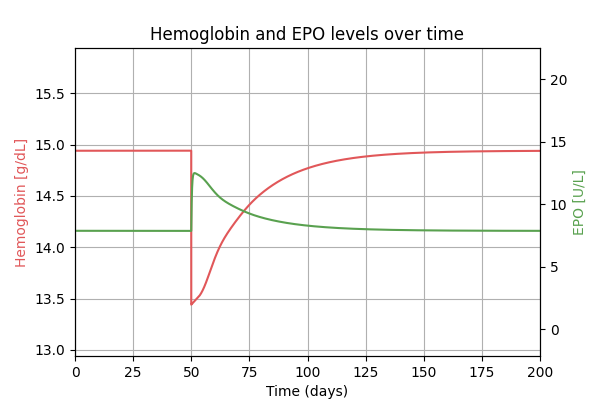

In [7]:
disease.run_simulation()
results = disease.results

# Plot the results
results.plot(x_higher_limit=200)

In [8]:
# Get time and hemoglobin arrays
t_days = results.t_days
hbg = results.hbg

# Step 1: Find the time of perturbation and index
perturbation_day = blood_loss["time_days"][0]
post_perturbation_mask = t_days >= perturbation_day

# Step 2: Find Hb minimum and steady state after perturbation
hbg_after = hbg[post_perturbation_mask]
t_after = t_days[post_perturbation_mask]

hbg_min = np.min(hbg_after)
hbg_final = hbg_after[-1]
hbg_threshold = hbg_min + 0.8 * (hbg_final - hbg_min)

# Step 3: Find the first time Hb exceeds the 80% threshold
recovery_index = np.argmax(hbg_after >= hbg_threshold)
recovery_time = t_after[recovery_index]

print(
    f"Hemoglobin recovered 80% of the blood loss after {recovery_time - perturbation_day:.2f} days (i.e., on day {recovery_time:.2f})"
)


Hemoglobin recovered 80% of the blood loss after 37.51 days (i.e., on day 87.51)


<AxesSubplot:title={'center':'Experimental validation'}, xlabel='Time (days)', ylabel='Hemoglobin [g/dL]'>

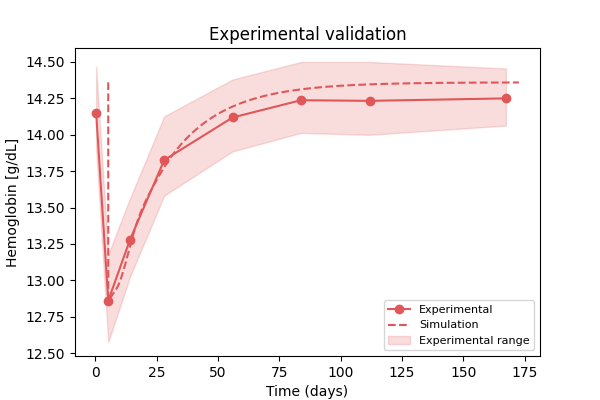

In [9]:
def plot_exp_vs_sim_on_axes(results, disease, blood_loss, consts, ax):
    """Draw the experimental comparison panel on a given Axes, return ax."""
    # timings
    perturbation_day = blood_loss["time_days"][0]
    t_purturbation = perturbation_day * 24 * 60 * 60
    step_purturbation = int(t_purturbation / disease.dt)

    # data
    xls_file = Path(
        "~/Library/Mobile Documents/com~apple~CloudDocs/Herut/Python/Homeostasis_feedback_loops/Hb_t/recovery_blood_loss.xlsx"
    ).expanduser()
    data = pd.read_excel(xls_file)
    time_days = data["day"].values
    hbg_exp = data["Hb"].values
    hbg_lower = data["error_bar_low"].values
    hbg_upper = data["error_bar_high"].values

    # align sim range
    hbg_gap = hbg_exp[1] - results.hbg[step_purturbation]
    t_index = np.where(results.t_days >= time_days[-1])[0][0] + step_purturbation

    # plot
    ax.plot(time_days, hbg_exp, "o-", label="Experimental", color=consts.c_color)
    ax.plot(
        results.t_days[step_purturbation - 1 : t_index]
        - blood_loss["time_days"]
        + time_days[1],
        results.hbg[step_purturbation - 1 : t_index] + hbg_gap,
        "--",
        color=consts.c_color,
        label="Simulation",
    )
    ax.fill_between(
        time_days,
        hbg_lower,
        hbg_upper,
        color=consts.c_color,
        alpha=0.2,
        label="Experimental range",
    )

    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Hemoglobin [g/dL]")
    ax.set_title("Experimental validation")
    ax.legend(fontsize=8)
    return ax


fig, ax = plt.subplots(figsize=(6, 4))
plot_exp_vs_sim_on_axes(results, disease, blood_loss, consts, ax)

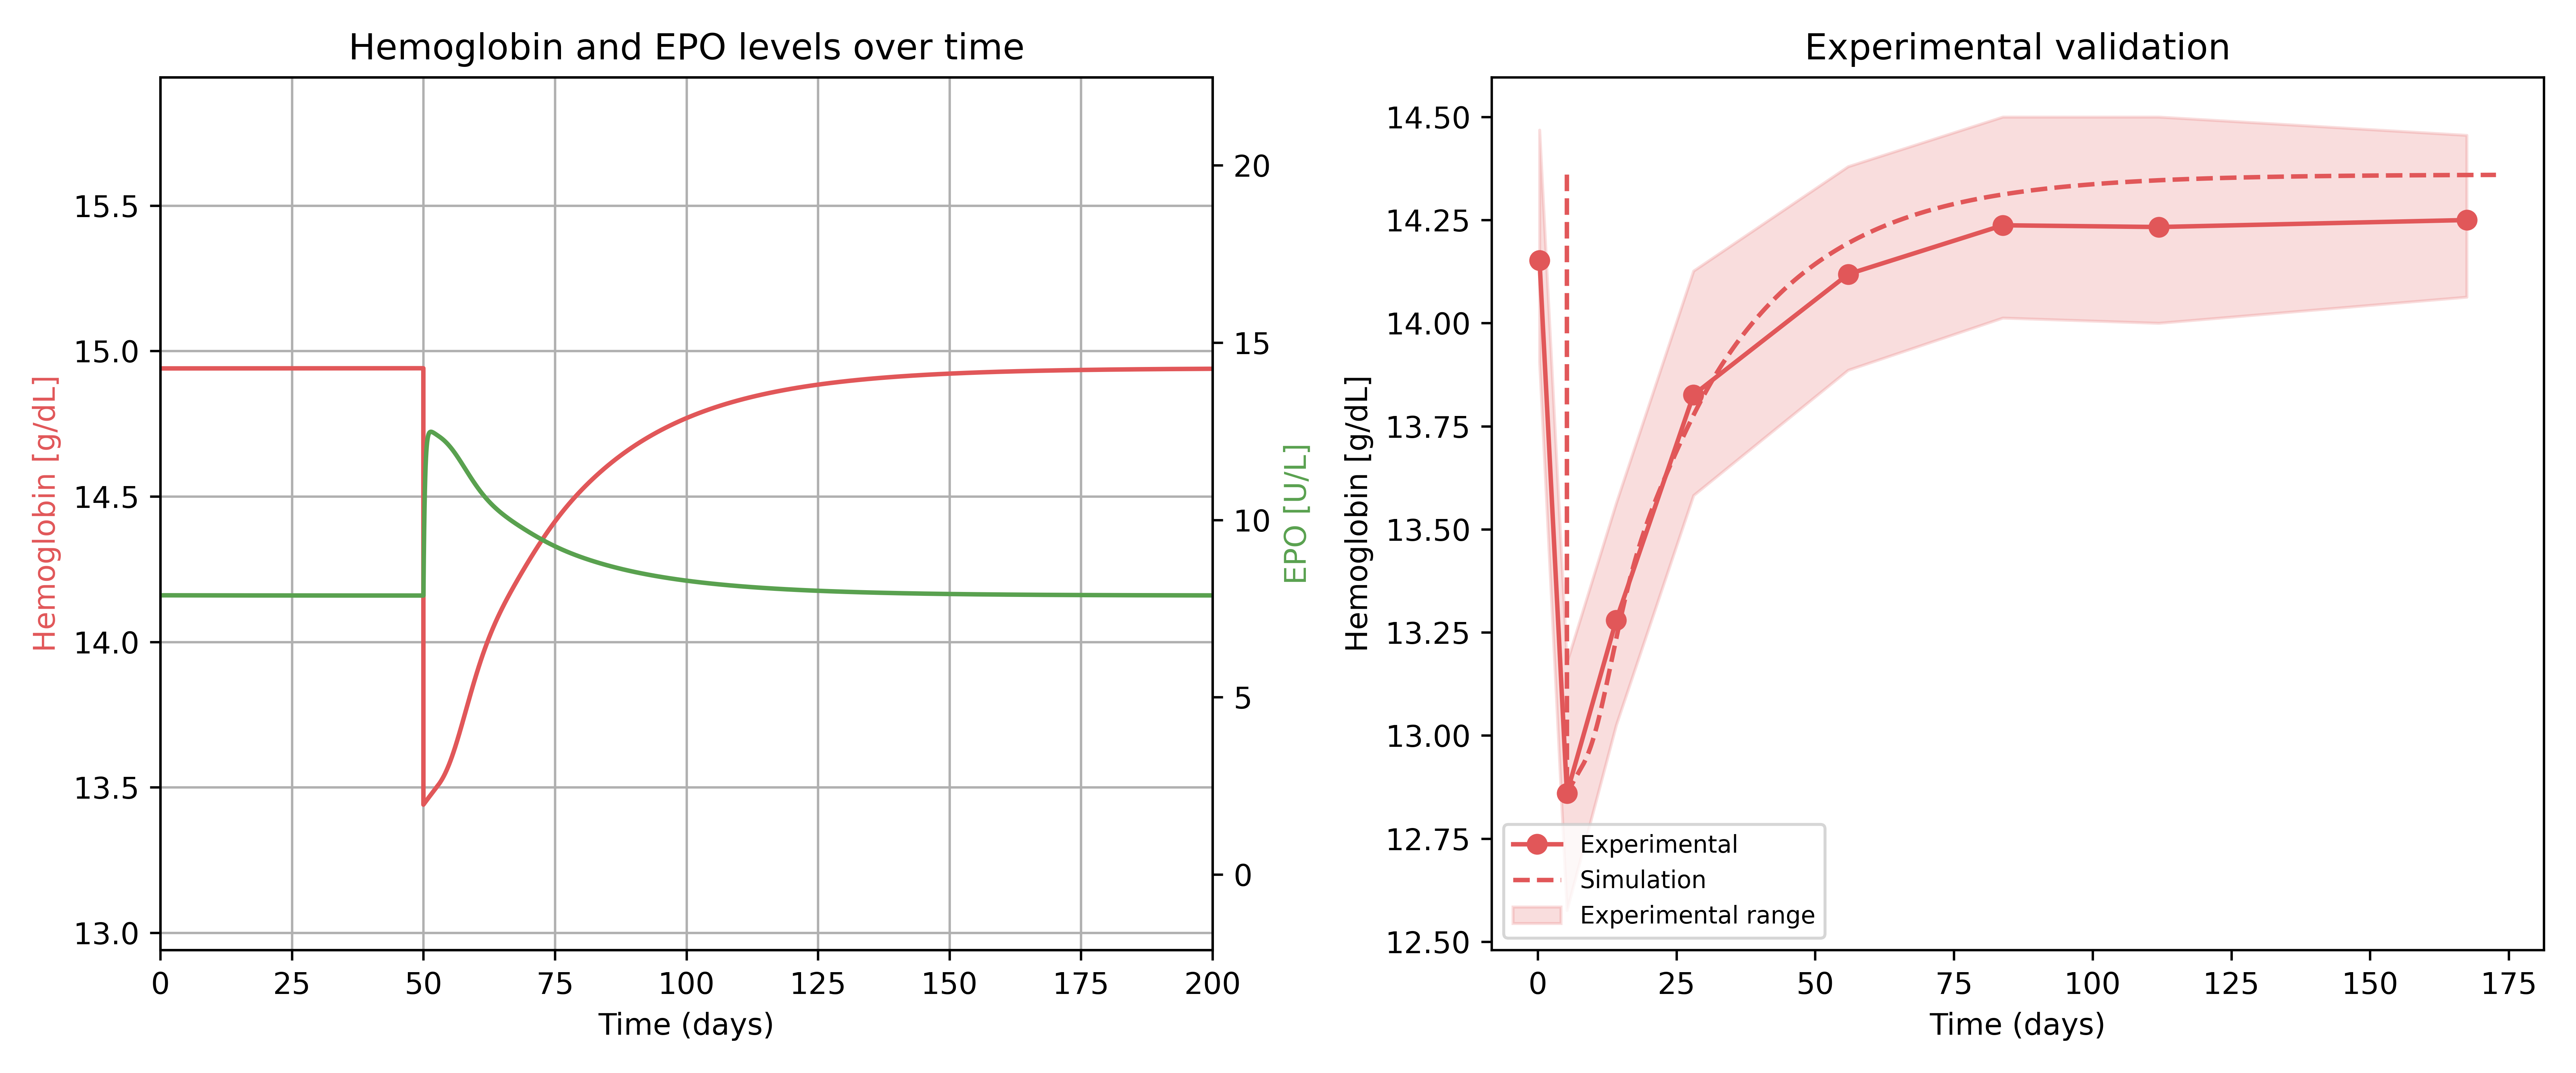

In [ ]:
# Create the multi-panel figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=600)

# Left panel: model
_, (ax1, ax1b) = results.plot(x_higher_limit=200, ax=ax1)

# Right panel: experiment vs simulation
plot_exp_vs_sim_on_axes(results, disease, blood_loss, consts, ax2)

# Tidy + save
fig.tight_layout()
fig.savefig(
    "Fig_combined.tiff",
    dpi=600,
    format="tiff",
    bbox_inches="tight",
    pil_kwargs={"compression": "tiff_lzw"},
)
plt.show()


## Aplastic anemia

In [6]:
disease = Disease("AA", modified_params={"h_max": consts.h_max_aa})

In [7]:
model = disease.model

100%|██████████| 49999/49999 [00:00<00:00, 71388.70it/s]



Steady state values:
Hemoglobin steady state: 8.63
EPO steady state: 371.21, which is 0.03% of maximal EPO
HSCc steady state: 1.02e+12, which is 10.16% of baseline
RBC steady state: 1.44e+13
Reticulocytes in bone marrow steady state: 2.92e+11
	 Reticulocytes percentage: 1.86%


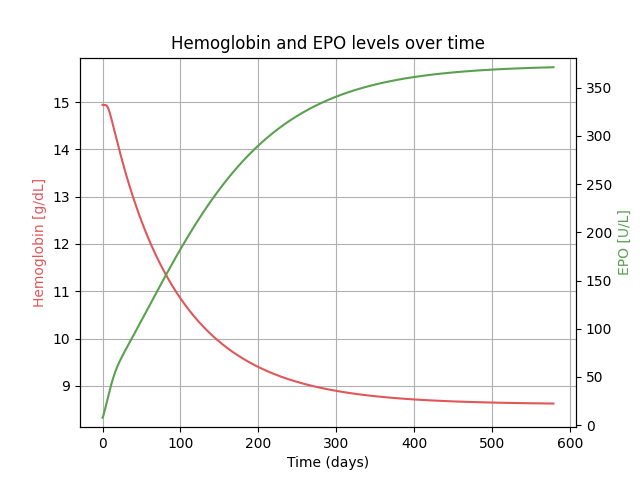

In [8]:
disease.run_simulation()
results = disease.results

# Plot the results
results.plot()


In [ ]:
disease.load_simulation_data(path)

In [9]:
disease.simulate_population_variability(n_samples=200, sd_params=sd_params)

100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


In [ ]:
results.calculate_steady_state(print_values=True)

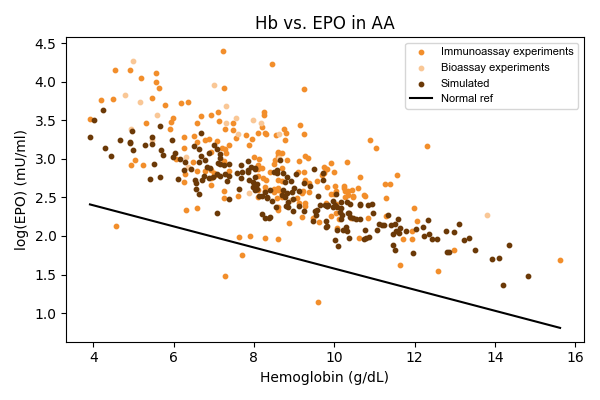

In [10]:
disease.compare_to_exp_data(save_fig=True)

In [ ]:
disease.print_stats()

In [ ]:
disease.calculate_wasserstein_distance()

In [ ]:
nullcline_plotter = disease.plot_nullclines()

In [ ]:
m, b = disease.fit_epo_curve()

In [ ]:
disease.print_exp_data()

In [ ]:
disease.save_simulation_data(path)

## CKD

The constants were based on the paper [Artunc, Ferruh, and Teut Risler. "Serum erythropoietin concentrations and responses to anaemia in patients with or without chronic kidney disease." Nephrology Dialysis Transplantation 22.10 (2007): 2900-2908.](https://academic.oup.com/ndt/article-abstract/22/10/2900/1830841?redirectedFrom=fulltext)

In [11]:
disease = Disease(
    "CKD",
    modified_params={
        "e_max": consts.E_MAX / 100,
        "c_normalization_epo": consts.C_NORMALIZATION * 10,
        "h_max": consts.H_MAX / 2,
    },
)

In [6]:
model = disease.model

In [ ]:
disease.run_simulation()
results = disease.results

# Plot the results
results.plot()

In [ ]:
results.plot_all(disease.dt, disease.t_end, purturbation=disease.perturbation)

In [ ]:
# disease.load_simulation_data(path)

In [12]:
disease.simulate_population_variability(n_samples=200, sd_params=sd_params)

100%|██████████| 200/200 [01:47<00:00,  1.85it/s]


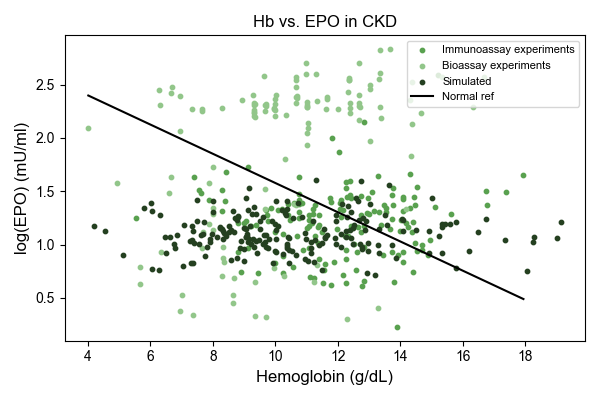

In [15]:
disease.compare_to_exp_data(save_fig=True)

In [ ]:
disease.print_stats()

In [ ]:
disease.calculate_wasserstein_distance()

In [ ]:
nullcline_plotter = disease.plot_nullclines()

In [ ]:
m, b = disease.fit_epo_curve()

In [ ]:
disease.print_exp_data()

In [ ]:
consts.E_MAX / 100


## Hemolytic anemia

In [16]:
rbc_life_span = 25  # days
gamma_c_ha = 1 / (rbc_life_span * 24 * 60 * 60)  # RBC degradation rate [1/sec]

disease = Disease("HA", modified_params={"gamma_c": gamma_c_ha})

In [ ]:
model = disease.model

In [ ]:
disease.run_simulation()
results = disease.results

# Plot the results
results.plot()

In [ ]:
E_st = (consts.E_MAX / (consts.GAMMA_E * results.h[-1])) * np.exp(
    -results.c[-1] / consts.C_NORMALIZATION
)
print(f"The steady state EPO level is: {E_st:.2f} U/L")

print(f"The intial EPO level is: {results.e[0]:.2f} U/L")
print(f"The final EPO level is: {results.e[-1]:.2f} U/L")

In [ ]:
# Calculate the excpected epo for a given hbg value according to: log_epo =
# -0.137 * hb + 2.947
hbg_value = consts.rbc_to_hbg(results.c[-1])  # g/dL
expected_epo = 10 ** (-0.137 * hbg_value + 2.947)
print(f"The expected EPO level for a Hb of {hbg_value} g/dL is: {expected_epo:.2f} U/L")


In [ ]:
disease.load_simulation_data(path)

In [17]:
disease.simulate_population_variability(n_samples=100, sd_params=sd_params)

100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


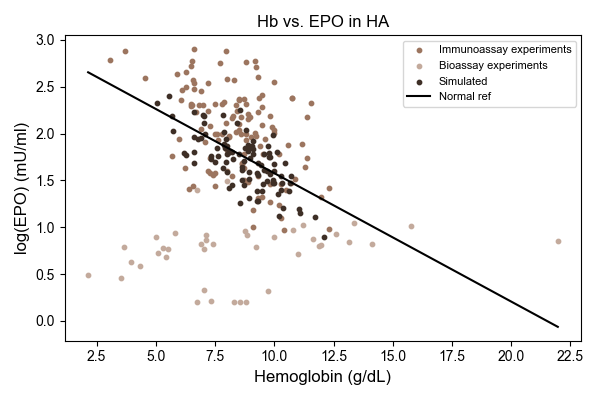

In [18]:
disease.compare_to_exp_data(save_fig=True)

In [ ]:
# Plot the expirimental data of Hemolytic anemia, give each data a unique color

path = (
    str(
        Path(
            "~/Library/Mobile Documents/com~apple~CloudDocs/Herut/"
            "Python/Homeostasis_feedback_loops/EPO_Hb"
        ).expanduser()
    )
    + "/"
)
files_names = glob.glob(path + "HA" + "*.xlsx")

plt.figure(figsize=(12, 10), dpi=80)
for file_name in files_names:
    data = pd.read_excel(file_name)
    Hb = data["Hb"].values
    log_EPO = data["logEPO"].values

    # random color for each file
    color = np.random.rand(
        3,
    )  # Generate a random RGB color

    plt.scatter(Hb, log_EPO, alpha=1, color=color, label=file_name.split("/")[-1])
plt.xlabel("Hemoglobin [g/dL]")
plt.ylabel("log(EPO) [U/L]")
plt.title("Hemoglobin and EPO levels in Hemolytic Anemia")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
disease.print_stats()

In [ ]:
disease.calculate_wasserstein_distance()

In [ ]:
nullcline_plotter = disease.plot_nullclines()

In [ ]:
m, b = disease.fit_epo_curve()

In [ ]:
disease.print_exp_data()

In [ ]:
disease.save_simulation_data(path)

## Anemia of chronic disease

In [19]:
disease = Disease("ACD", modified_params={"d_max": consts.d_max_acd})

In [ ]:
model = disease.model

In [ ]:
disease.run_simulation()
results = disease.results

# Plot the results
results.plot()


In [ ]:
disease.load_simulation_data(path)

In [20]:
disease.simulate_population_variability(n_samples=300, sd_params=sd_params)

100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


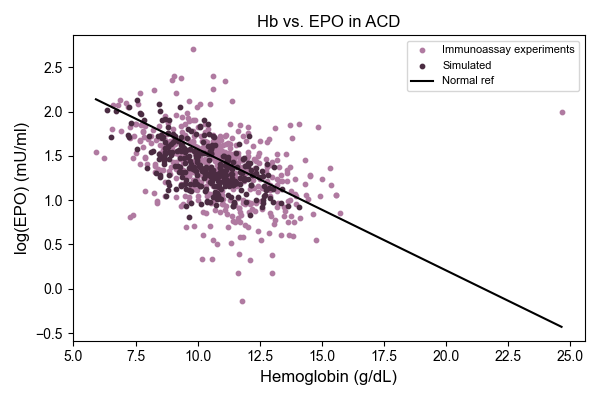

In [21]:
disease.compare_to_exp_data(save_fig=True)

In [ ]:
disease.print_stats()

In [ ]:
disease.calculate_wasserstein_distance()

In [ ]:
nullcline_plotter = disease.plot_nullclines()

In [ ]:
m, b = disease.fit_epo_curve()

In [ ]:
disease.print_exp_data()

In [ ]:
disease.save_simulation_data(path)

## Iron deficency anemia

In [22]:
disease = Disease(
    "IDA",
    modified_params={
        "d_max": consts.D_MAX / 3,
        "a_max": consts.A_MAX / 3,
    },
)

In [ ]:
model = disease.model

In [ ]:
disease.run_simulation()
results = disease.results

# Plot the results
results.plot()


In [ ]:
disease.load_simulation_data(path)

In [23]:
disease.simulate_population_variability(n_samples=150, sd_params=sd_params)

100%|██████████| 150/150 [01:14<00:00,  2.02it/s]


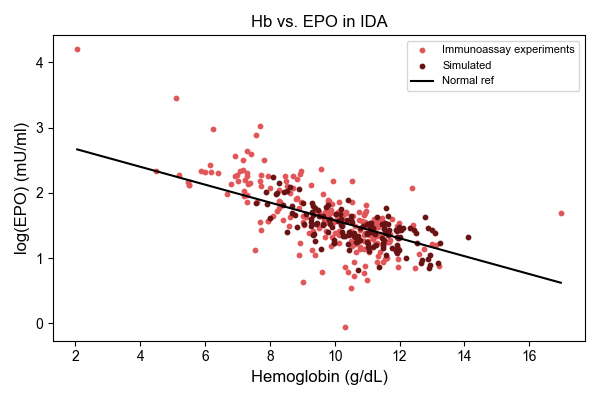

In [24]:
disease.compare_to_exp_data(save_fig=True)

In [ ]:
disease.print_stats()

In [ ]:
disease.calculate_wasserstein_distance()

In [ ]:
nullcline_plotter = disease.plot_nullclines()

In [ ]:
m, b = disease.fit_epo_curve()

In [ ]:
disease.print_exp_data()

In [ ]:
disease.save_simulation_data(path)

# Calculation

## Calculating the parmeters
D and sigma_max by the relationship between EPO and hemoglobin

In [ ]:
# Load the data
path = (
    str(
        Path(
            "~/Library/Mobile Documents/com~apple~CloudDocs/Herut/"
            "Python/Homeostasis_feedback_loops/EPO_Hb"
        ).expanduser()
    )
    + "/"
)
files_names = glob.glob(path + "norm" + "*.xlsx")

log_EPO_all = []
Hb_all = []

for file_name in files_names:
    data = pd.read_excel(file_name)
    log_EPO_all.extend(data["logEPO"].values)
    Hb_all.extend(data["Hb"].values)

# Convert to arrays
Hb_all = np.array(Hb_all)
log_EPO_all = np.array(log_EPO_all)
ln_EPO_all = log_EPO_all * np.log(10)  # Convert from log10 to natural log

# 1. Linear fit: ln(EPO) = A * Hb + B
A, B = np.polyfit(Hb_all, ln_EPO_all, 1)
print(f"Linear model: ln(EPO) = {A:.4f} * Hb + {B:.4f}")

# 2. Nonlinear fit: EPO = C * exp(D / Hb)
# Convert ln(EPO) to EPO
EPO_all = np.exp(ln_EPO_all)
C = np.exp(B)  # C is the intercept of the linear fit
D = A  # D is the slope of the linear fit
print(f"Nonlinear model: EPO = {C:.4f} * exp({D:.4f} * Hb)")

# Calculate E_max
E_max_calculated = consts.LAMBDA_E * C
print(f"Calculated E_max: {E_max_calculated:.4f} U/L")
print(f"Given E_max: {consts.E_MAX} U/L")

# Calculate C_normalization
C_normalization_calculated = consts.hbg_to_rbc(-1 / D)
print(f"Calculated C_normalization: {C_normalization_calculated:.4e} cells")
print(f"Given C_normalization: {consts.C_NORMALIZATION:.4e} cells")

Gamma_E

In [ ]:
# E_steady_state * lambda_E = 4e-4
E_steady_state = 10  # U/L
H_steady_state = consts.H_0
lambda_E = 4e-4 / E_steady_state
gamma_E = lambda_E / H_steady_state  # Endocytosis mechanism rate
print(f"Calculated gamma_E: {gamma_E:.4e} 1/sec")
print(f"Given gamma_E: {consts.GAMMA_E:.4e} 1/sec")

gamma_C

In [ ]:
files_names

In [ ]:
rbc_life_span = 120  # days
# convert to seconds
rbc_life_span_seconds = rbc_life_span * 24 * 60 * 60

gamma_c_calculated = 1 / rbc_life_span_seconds  # RBC degradation rate [1/sec]
print(f"Calculated gamma_c: {gamma_c_calculated:.8e} 1/sec")

## Calculate weighted mean and sd

In [ ]:
means = np.array([56, 395])
stds = np.array([63, 195])
num_samples = np.array([10, 4])

# Calculate the weighted mean
mean = np.sum(num_samples * means) / np.sum(num_samples)

# Calculate the weighted standard deviation
E_x2 = np.sum(num_samples * (stds**2 + means**2)) / np.sum(num_samples)
std = np.sqrt(E_x2 - mean**2)

# Print the results
print(f"Weighted mean: {mean:.4f} g/dL")
print(f"Weighted standard deviation: {std:.4f} g/dL")

## The relationship between EPO and CFU-E cell count

In [ ]:
# Calculate a_max and k_a acoording to Sawada, K., et al., 1987

import numpy as np
import matplotlib.pyplot as plt


# Calculate the geometric mean
def geometric_mean(x):
    return np.exp(np.mean(np.log(x)))


# Calculate a_max
num_cells_range = [8, 49]

num_colonies_final = 195
num_cells_initial = 250
experiment_days = 6

cells_per_colony = geometric_mean(num_cells_range)
cell_ratio = num_colonies_final * cells_per_colony / num_cells_initial
log_cell_ratio = np.log(cell_ratio)

a_max_days = log_cell_ratio / experiment_days
a_max = a_max_days / 24 / 3600  # 1/sec

# Calculate k_a
a_half = a_max_days / 2
num_cells_half = num_cells_initial * np.exp(a_half * experiment_days)
num_colonies_final_half = num_cells_half / cells_per_colony
k_a = (
    0.03 * 1000
)  # (mU/mL), observed in paper graph, using a_half and num_colonies_final_half


epo = np.array([0, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2, 4]) * 1000  # mU/ml

n = 1.0
a = a_max * epo**n / (k_a**n + epo**n)
a_days = a * 24 * 3600  # 1/day
cell_ratio_theory = np.exp(a_days * experiment_days)
cfu_e = num_cells_initial * cell_ratio_theory / cells_per_colony

# Prunt the parameters: a_max, k_a
print(f"a_max: {a_max:.2e}")
print(f"k_a: {k_a:.2e}")

# plot scatter plot of the relation between EPO and CFU-E
plt.figure()
# plt.scatter(epo, cfu_e)
# add line plot
# Plot the line with the data points marked.
plt.plot(epo / 1000, cfu_e, marker="o")
# Put tickmarks at each EPO concentration.
plt.xticks(epo / 1000)
# Put labels at each EPO concentration.
for i, txt in enumerate(epo):
    plt.annotate(
        txt / 1000,
        (epo[i] / 1000, cfu_e[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )
# change the x-axis to log scale
plt.xscale("log")
plt.xlabel("EPO (U/ml)")
plt.ylabel("CFU-E (colonies)")
plt.title("CFU-E production rate vs. EPO concentration")
plt.show()

In [ ]:
a_max = 195 / 250  # units/sec
k_a = 0.05  # units/ml

a_max_sec = a_max / (6 * 24 * 60 * 60)  # units/min

# print the CFU-E value for specific EPO value
epo_value = 10 / 1000  # U/ml
cfu_e_value = a_max_sec * epo_value**2 / (k_a**2 + epo_value**2)
# the number of cells is expected to be very small, so we'll print it in
# scientific notation
print(f"CFU-E production rate for EPO = {epo_value} U/ml: {cfu_e_value:.2e} cells/sec")

In [ ]:
# plot the function y = x(1-x)
x = np.linspace(0, 1, 100)
y = x * (1 - x)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("y = x(1-x)")
plt.show()

## Average calculation

In [ ]:
# Calculate weighted mean
def weighted_mean(values, weights):
    return np.sum(values * weights) / np.sum(weights)


def weighted_std(values, weights):
    mean = weighted_mean(values, weights)
    variance = np.sum(weights * (values - mean) ** 2) / np.sum(weights)
    return np.sqrt(variance)


# Example usage
values = np.array([1, 2, 3, 4, 5])
weights = np.array([11, 10, 8, 11])

# normalize weights
weights = weights / np.sum(weights)

mean = weighted_mean(values, weights)
std = weighted_std(values, weights)

print(f"Weighted mean: {mean:.2f}")
print(f"Weighted std: {std:.2f}")